# Breast Cancer Homework

### Giulio Scarpa - matricola: 995914

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import norm, zscore
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression           
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [2]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).mean()

In [3]:
def show_results(cv, X_test, params, prefix=''):
    prefix = ' '+prefix    
    results = pd.DataFrame(cv.cv_results_)
   
    plt.plot(results[params], results['mean_test_score'], label=prefix)

   
    best_idx = np.argmax(results['mean_test_score'])
    
    plt.plot(results[params][best_idx],results['mean_test_score'][best_idx],marker='X')
    plt.legend()

    print(prefix, f"(best {results[params][best_idx]}) CV sensitivity:",  cv.best_score_)
    print(prefix, f"(best {results[params][best_idx]}) Test sensitivity:", recall_score(y_test, cv.best_estimator_.predict(X_test)))

# Data Preparation

In [4]:
df = pd.read_csv("breast-cancer-wisconsin.data")

##### Adding header with feature name

In [5]:
df.to_csv("breast-cancer-wisconsin.data", header=['ID','Thickness','U_Cell_Size','U_Cell_Shape','Marginal_Adhesion','S_E_Cell_Size',
                                       'Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','Class'], index=False)

In [6]:
df

,ID,Thickness,U_Cell_Size,U_Cell_Shape,Marginal_Adhesion,S_E_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [7]:
df = df.replace(['?'],np.nan) # replacing incorrect values

In [8]:
df.isna().sum().sum()

16

In [9]:
df = df.dropna() # removing rows with NULL values

In [10]:
pd.DataFrame(df.dtypes, columns = ["Data Type"]) # checking feature data type

,Data Type
ID,int64
Thickness,int64
U_Cell_Size,int64
U_Cell_Shape,int64
Marginal_Adhesion,int64
S_E_Cell_Size,int64
Bare_Nuclei,object
Bland_Chromatin,int64
Normal_Nucleoli,int64
Mitoses,int64


In [11]:
df['Bare_Nuclei'] = df['Bare_Nuclei'].astype('int64') # changing 'Bare_Nuclei' datatype to'int64'

In [12]:
df['Class'] = df['Class'].replace({4: 1.0, 2:0.0}) # modifing 'Class' values to 0/1

In [13]:
df = df.drop('ID', axis = 1) # dropping 'ID' column (it's pointless for my task)

#### Using a correlation matrix help to find statistical association between the varibales inside the dataset, in this case the strongest correlation we can find is between cell size and cell shape

[0.71478993 0.82080144 0.82189095 0.70629414 0.69095816 0.82269587
 0.75822755 0.71867719 0.42344792 1.        ]


<AxesSubplot:>

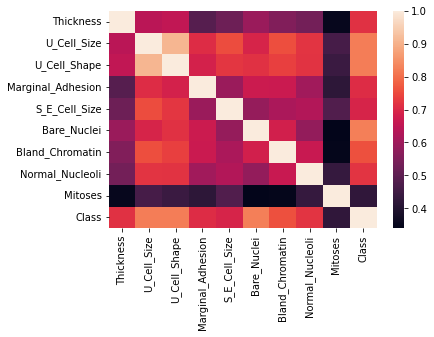

In [14]:
print(df.corr().to_numpy()[:,-1])
sns.heatmap(df.corr())

##### Looking to the plot I noticed that all variables have the same scale so it makes pointless to normilize the data, another thing to point out is the unbalance of the dataset, as we can see by the distributions below

<function matplotlib.pyplot.show(close=None, block=None)>

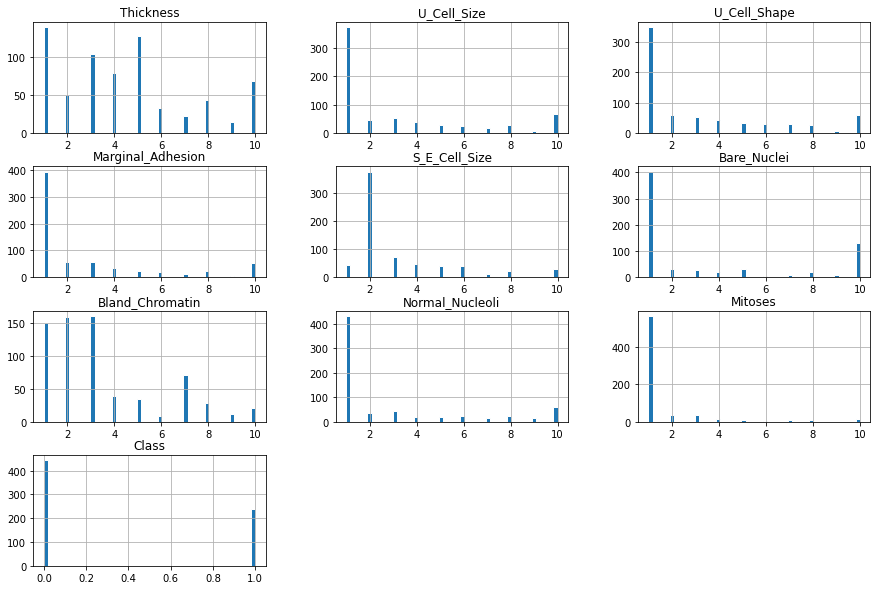

In [15]:
df.hist(bins=50, figsize=(15,10), ec = 'w')
plt.show

In [16]:
X = df.drop("Class", axis = 1)    # select all other feature except "Class" for training
y = df['Class'].to_numpy()

# Models for Classification

#### Before start with the model evaluation I decide for this task to use as evaluation score the sensitivity, not the accuracy, because being this dataset about medical data, I want in my models the prioritization of the sensitivity over the accuracy in order to minimize the probability to have patients classified as false negative. In this way a patient classified as false positive will be subject to further analysis, but a patient classified as false negative will be discarded with all the consequences for her/his health

In [17]:
split_seed = 42
split_test_size = 0.3 # fixind the size to 30% data to the test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split_test_size, 
                                                    random_state=split_seed,
                                                    stratify = y)

## Logistic Regression

In [19]:
model = LogisticRegression(solver='newton-cg', penalty='none')
model.fit(X_train, y_train)                               
y_predict = model.predict(X_train)                        

print("Train sensitivity:", recall_score(y_train, model.predict(X_train)))
print("Test sensitivity:", recall_score(y_test, model.predict(X_test)))

Train sensitivity: 0.9640718562874252
Test sensitivity: 0.9444444444444444


## Linear Discriminant Analysis

In [20]:
model = LDA(store_covariance=True)
model = model.fit(X_train, y_train)

print("Train sensitivity:", recall_score(y_train, model.predict(X_train)))
print("Test sensitivity:", recall_score(y_test, model.predict(X_test)))

Train sensitivity: 0.9341317365269461
Test sensitivity: 0.8888888888888888


#### Here I tested LDA with different degree polynomial to see which was the best degree and it appeard to be the second, it means that data are not linearly separable

  (best 2) CV sensitivity: 0.9283088235294118
  (best 2) Test sensitivity: 0.9305555555555556
None


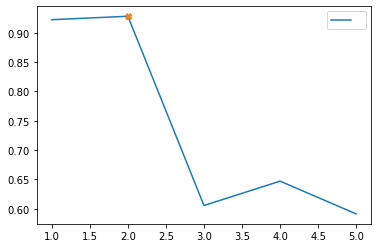

In [21]:
#polynomial
model = Pipeline([
    ('poly', PolynomialFeatures()),
    ('lda', LDA(store_covariance=True))])
model = model.fit(X_train, y_train)

params = {'poly__degree': range(1, 6)}
cv = GridSearchCV(model, params, refit=True, cv=10, 
                  scoring=make_scorer(recall_score))
cv.fit(X_train, y_train)
cv.best_params_
cv.best_score_
print(show_results(cv, X_test, 'param_poly__degree'))

In [22]:
pd.DataFrame(cv.cv_results_) 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.008634,0.001071,0.004200,0.000601,1,{'poly__degree': 1},0.9375,0.882353,0.823529,1.000000,0.882353,0.941176,0.941176,0.941176,1.0000,0.8750,0.922426,0.053441,2
1,0.014298,0.000780,0.004900,0.000537,2,{'poly__degree': 2},0.9375,0.882353,0.882353,1.000000,0.941176,0.941176,0.882353,0.941176,1.0000,0.8750,0.928309,0.044764,1
2,0.051680,0.001981,0.005354,0.001100,3,{'poly__degree': 3},0.6875,0.411765,0.470588,0.647059,0.588235,0.705882,0.764706,0.529412,0.6875,0.5625,0.605515,0.106897,4
3,0.179068,0.008168,0.006150,0.003674,4,{'poly__degree': 4},0.6875,0.647059,0.705882,0.588235,0.588235,0.529412,0.647059,0.764706,0.6875,0.6250,0.647059,0.064668,3
4,0.647664,0.018712,0.005051,0.000474,5,{'poly__degree': 5},0.2500,0.588235,0.764706,0.529412,0.588235,0.529412,0.764706,0.647059,0.6250,0.6250,0.591176,0.137726,5


## Quadratic Discriminant Analysis

In [23]:
model = QDA(store_covariance = True)
model = model.fit(X_train, y_train)

print("Train sensitivity:", recall_score(y_train, model.predict(X_train)))
print("Test sensitivity:", recall_score(y_test, model.predict(X_test)))

Train sensitivity: 0.9820359281437125
Test sensitivity: 0.9583333333333334


## K-Nearest Neighbors

#### Using cross-validation method with 10 folds in a range of 40 k, the best value of k is 3

In [24]:
model = KNeighborsClassifier()
params = {'n_neighbors': range(1, 40)}
folds=10
scorer = make_scorer(recall_score)

cv = GridSearchCV(model, params, refit=True, cv = folds, scoring = scorer)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 40)},
             scoring=make_scorer(recall_score))

  (best 3) CV sensitivity: 0.9639705882352942
  (best 3) Test sensitivity: 0.9444444444444444


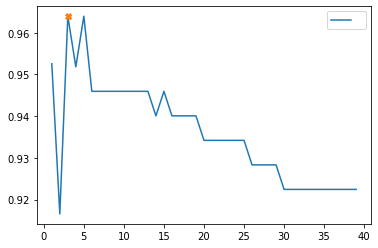

In [25]:
show_results(cv, X_test, "param_n_neighbors")

## Support Vector Machine

#### This time I tried the SVM model with cross-validation and with three different kernel (poly, RBF, Sigmoid) to see which kernel is the best with which best value of regularization parameter C

In [26]:
# Polynomial
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [1, 2, 3, 4]}
svm_poly_rec = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='recall', refit=True)
svm_poly_rec.fit(X_train, y_train)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly_rec = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='recall', refit=True)
rbf_poly_rec.fit(X_train, y_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly_rec = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring='recall', refit=True)
sigm_poly_rec.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             scoring='recall')

In [27]:
for m in [svm_poly_rec, rbf_poly_rec, sigm_poly_rec]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    train_sensitivity = recall_score(y_train, m.predict(X_train))
    test_sensitivity = recall_score(y_test, m.predict(X_test))
    print("cv score: {}".format(cv_score))
    print("train score: {}".format(train_sensitivity))
    print("test score: {}\n".format(test_sensitivity))

SVC(C=100.0, coef0=-10.0, degree=1, kernel='poly')
cv score: 0.9641711229946524
train score: 0.9700598802395209
test score: 0.9583333333333334

SVC(C=25.00075, gamma=0.001)
cv score: 0.9581105169340465
train score: 0.9700598802395209
test score: 0.9583333333333334

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
cv score: 0.9581105169340465
train score: 0.9640718562874252
test score: 0.9583333333333334



#### After seeing the results where all kernels had the same scores using recall as scorer, I decided to try the accuracy scorer to see which kernel was the best

In [28]:
# Polynomial
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [1, 2, 3, 4]}
svm_poly_acc = GridSearchCV(SVC(kernel='poly'), param_grid,
                        cv=5, scoring='accuracy', refit=True)
svm_poly_acc.fit(X_train, y_train)

# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
rbf_poly_acc = GridSearchCV(SVC(kernel='rbf'), param_grid, 
                        cv=5, scoring='accuracy', refit=True)
rbf_poly_acc.fit(X_train, y_train)

# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
sigm_poly_acc = GridSearchCV(SVC(kernel='sigmoid'), param_grid, 
                         cv=5, scoring='accuracy', refit=True)
sigm_poly_acc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02]),
                         'coef0': array([-10.,  -5.,   0.,   5.,  10.]),
                         'gamma': array([1.000000e-03, 2.500075e+01, 5.000050e+01, 7.500025e+01,
       1.000000e+02])},
             scoring='accuracy')

In [29]:
for m in [svm_poly_acc, rbf_poly_acc, sigm_poly_acc]:
    cv_score = m.best_score_
    m = m.best_estimator_
    print(m)
    train_acc = accuracy(y_train, m.predict(X_train))
    test_acc = accuracy(y_test, m.predict(X_test))
    print("cv score: {}".format(cv_score))
    print("train score: {}".format(train_acc))
    print("test score: {}\n".format(test_acc))

SVC(C=0.001, coef0=5.0, degree=4, kernel='poly')
cv score: 0.9728070175438596
train score: 0.9790794979079498
test score: 0.9560975609756097

SVC(C=25.00075, gamma=0.001)
cv score: 0.9728070175438596
train score: 0.9811715481171548
test score: 0.9609756097560975

SVC(C=25.00075, gamma=0.001, kernel='sigmoid')
cv score: 0.9728070175438596
train score: 0.9769874476987448
test score: 0.9609756097560975



#### In the end I choosed Sigmoid kernel as the best for the higest accuracy score

## Best Model

#### Keeping only sigmoid as best kernel for SVM, I compared it and the other four models to decide which was the best using recall and accuracy as scorers

lda CV score sensitivity: 0.9283,  test score sensitivity: 0.9306
log CV score sensitivity: 0.9460,  test score sensitivity: 0.9444
qda CV score sensitivity: 0.9816,  test score sensitivity: 0.9583
knn CV score sensitivity: 0.9640,  test score sensitivity: 0.9444
svm_sigm CV score sensitivity: 0.9577,  test score sensitivity: 0.9583
lda CV score accuracy: 0.9645,  test score accuracy: 0.9512
log CV score accuracy: 0.9665,  test score accuracy: 0.9561
qda CV score accuracy: 0.9478,  test score accuracy: 0.9561
knn CV score accuracy: 0.9812,  test score accuracy: 0.9561
svm_sigm CV score accuracy: 0.9749,  test score accuracy: 0.9610


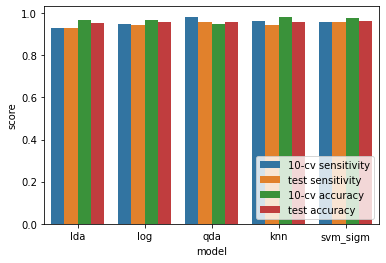

In [30]:
log = LogisticRegression(solver='newton-cg', penalty='none')
lda = Pipeline([('poly', PolynomialFeatures(degree=2)), ('lda', LDA(store_covariance=True))])
qda = QDA(store_covariance = True) 
knn = KNeighborsClassifier(n_neighbors=3)
svm_sigm = SVC(kernel='sigmoid', gamma = 0.001, C=25, probability= True)


from collections import OrderedDict
models = OrderedDict([('lda', lda), ('log', log), ('qda', qda), ('knn', knn), ('svm_sigm', svm_sigm)])

cv_scores_rec, test_scores_rec = [], []
for name, model in models.items():
    scores_rec = cross_val_score(model, X_train, y_train, cv=10, scoring = make_scorer(recall_score))
    cv_score_rec = np.mean(scores_rec)
    cv_scores_rec.append(cv_score_rec)
    
    model.fit(X_train, y_train) 
    test_score_rec = recall_score(y_test, model.predict(X_test))
    test_scores_rec.append(test_score_rec)
    print("{} CV score sensitivity: {:.4f},  test score sensitivity: {:.4f}".format(name, cv_score_rec, test_score_rec))

cv_scores_acc, test_scores_acc = [], []
for name, model in models.items():
    scores_acc = cross_val_score(model, X_train, y_train, cv=10, scoring = make_scorer(accuracy))
    cv_score_acc = np.mean(scores_acc)
    cv_scores_acc.append(cv_score_acc)
    
    model.fit(X_train, y_train) 
    test_score_acc = accuracy(y_test, model.predict(X_test))
    test_scores_acc.append(test_score_acc)
    print("{} CV score accuracy: {:.4f},  test score accuracy: {:.4f}".format(name, cv_score_acc, test_score_acc))
    
    
data = pd.DataFrame()
data['model'] = list(models.keys()) * 4
data['metric'] = ['10-cv sensitivity'] * len(cv_scores_rec) + ['test sensitivity'] * len(test_scores_rec) + ['10-cv accuracy'] * len(cv_scores_acc) + ['test accuracy'] * len(test_scores_acc)
data['score'] = cv_scores_rec + test_scores_rec + cv_scores_acc + test_scores_acc

sns.barplot(x='model', y='score', data=data, hue='metric')
plt.legend(loc='lower right')



#### The best models according to the recall are both the SVM with Sigmoid and QDA, but according to both the recall and accuracy the SVM Sigmoid is the best

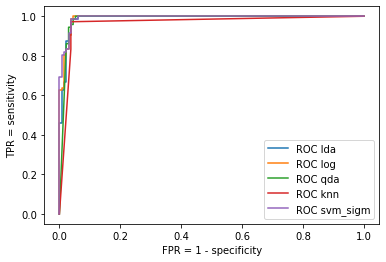

In [31]:
from sklearn.metrics import roc_curve

def plot_roc(predict_fn, X, y, label=None):
    fprs, tprs, t = roc_curve(y, predict_fn(X)[:,-1])
    
    # Plot the ROC
    plt.plot(fprs, tprs, label="ROC "+label)
    plt.xlabel("FPR = 1 - specificity")
    plt.ylabel("TPR = sensitivity")
    plt.legend()

for name, model in [('lda', lda), ('log', log), ('qda', qda), ('knn', knn), ('svm_sigm', svm_sigm)]:
    model.fit(X_train, y_train)
    plot_roc(model.predict_proba, X_test, y_test, name)

#### I conclude with the plot of the ROC curve which in this case isn't much informative to compare the models but can easily show that more or less all models used for this task perform well on this data